This notebook is an example of EBSD scan processing. Here we only process a small region of interest to speed up the calculation, but the processing can (and is usually done) on the whole map. The processing (done using the `OimScan` class) basically consist in loading the data, creating the crysallographic phases and segmenting the grains. Note that from the user point of view, the processing is usually done with the `Microstructure` class using the `from_ebsd` function (see the end of the notebook for this).

In [3]:
from pymicro.crystal.ebsd import OimScan
from pymicro.crystal.lattice import Lattice, CrystallinePhase, Symmetry
from pymicro.crystal.microstructure import Microstructure
import numpy as np
from matplotlib import pyplot as plt, cm

### Using the OimScan class

In [57]:
roi, ds = None, 1
roi, ds = [300, 700, 700, 1000], 2
scan = OimScan.from_file('EBSD_T40_.ctf', crop=(roi, ds), use_spatial_ref_frame=True)

EBSD_T40_ .ctf
using ref_frame 4
guessed symmetry from lattice parameters: Symmetry.hexagonal
adding phase Phase 1 (Ti-Hex) 
	-- Lattice (Symmetry.hexagonal) a=0.300, b=0.300, c=0.470 alpha=90.0, beta=90.0, gamma=120.0
hexagonal symmetry, adding 30 degrees rotation around c-axis
importing data from region [300, 700, 700, 1000]
downsampling data by a factor 2
using spatial reference frame for orientation data


changing orientation reference frame progress: 100%|██████████| 29313/29313 [00:01<00:00, 14842.46it/s]

In [58]:
scan

EBSD scan of size 200 x 150
|- spatial resolution: x=0.5, y=0.5
|- phase 1 (Symmetry.hexagonal)

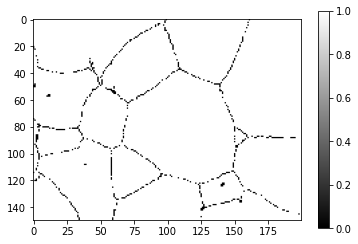

In [64]:
plt.imshow((scan.phase).T, cmap=cm.gray)
plt.colorbar()

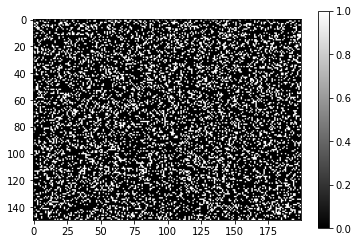

In [68]:
plt.imshow((scan.ci > 0.2).T, cmap=cm.gray)
plt.colorbar()

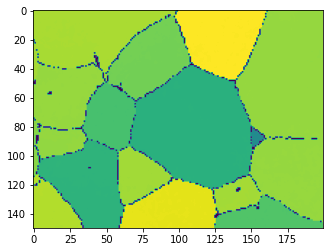

In [5]:
plt.imshow(scan.euler[:, :, 0].T)

In [59]:
# this can be long for the full EBSD data set
scan.compute_ipf_maps()

computing IPF maps for phase 1 (Symmetry.hexagonal): 100%|██████████| 29313/29313 [00:04<00:00, 6618.41it/s]


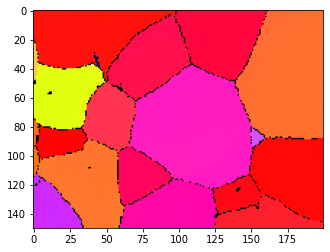

In [60]:
plt.imshow(scan.ipf100.transpose(1, 0, 2))

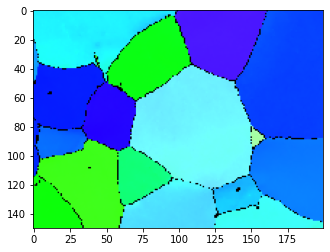

In [61]:
plt.imshow(scan.ipf010.transpose(1, 0, 2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


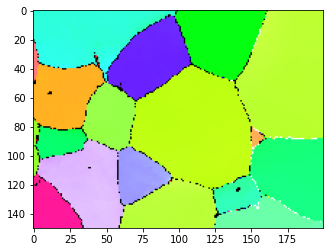

In [9]:
plt.imshow(scan.ipf001.transpose(1, 0, 2))

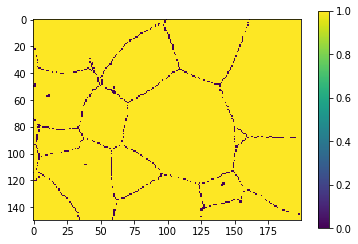

In [10]:
plt.imshow((scan.phase).T, interpolation='nearest')
plt.colorbar()
plt.show()

In [11]:
# CI field is not meaningful here
scan.ci = scan.phase.copy().astype(float)
scan.ci.min(), scan.ci.max()

(0.0, 1.0)

In [2]:
import pymicro

In [5]:
!code /home/pbelamriregenpied1/Documents/pymicro/pymicro/pymicro

In [69]:
scan.segment_grains(tol=5., min_ci=-0.1)

grain segmentation for EBSD scan, misorientation tolerance=5.0, minimum confidence index=-0.1
segmentation progress: 100.00 %
23 grains were segmented


array([[ 1,  1,  1, ..., 19, 19, 19],
       [ 1,  1,  1, ..., 19, 19, 19],
       [ 1,  1,  1, ..., 19, 19, 19],
       ...,
       [ 3,  3,  3, ..., 22, 22, 22],
       [ 3,  3,  3, ..., 22, 22, 22],
       [ 3,  3,  3, ..., 22, 22, 22]])

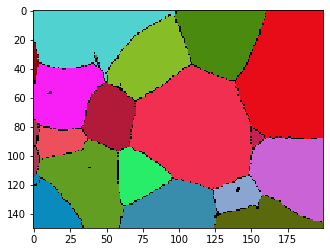

In [70]:
# plot the segmented grain structure using a random color map: each color represents a grain
rand_cmap = Microstructure.rand_cmap(first_is_black=True)
plt.imshow(scan.grain_ids.T, cmap=rand_cmap, interpolation='nearest')
plt.show()

In [14]:
# observe that the crystal symmetry is hexagonal
sym = scan.phase_list[0].get_symmetry()
print(sym)

Symmetry.hexagonal


In [15]:
from pymicro.crystal.microstructure import Orientation

# compute the disorientation between grains 2 and 3
print(scan.grain_ids[125, 20])
o2 = Orientation.from_euler(np.degrees(scan.euler[125, 20, :]))
print(scan.grain_ids[175, 50])
o3 = Orientation.from_euler(np.degrees(scan.euler[175, 50, :]))
mis_angle = np.degrees(o2.disorientation(o3, crystal_structure=sym)[0])
print('misorientation between grains 2 and 3 is %.1f degrees' % mis_angle)

2
3
misorientation between grains 2 and 3 is 36.5 degrees


### Using the Microstructure class

In [7]:
from pymicro.crystal.microstructure import Microstructure

# directly import the EBSD data, here we chose not to take the confidence index into account
m = Microstructure.from_ebsd('EBSD_T40_.ctf', roi=[300, 700, 700, 1000], ds=2, tol=5., min_ci=-1.)#, grain_ids=scan.grain_ids)

0 phases found in the data set
new phase added: unknown
EBSD_T40_ .ctf
using ref_frame 4
guessed symmetry from lattice parameters: Symmetry.hexagonal
adding phase Phase 1 (Ti-Hex) 
	-- Lattice (Symmetry.hexagonal) a=0.300, b=0.300, c=0.470 alpha=90.0, beta=90.0, gamma=120.0
hexagonal symmetry, adding 30 degrees rotation around c-axis
importing data from region [300, 700, 700, 1000]
downsampling data by a factor 2
using spatial reference frame for orientation data


changing orientation reference frame progress: 100%|██████████| 29313/29313 [00:01<00:00, 15782.28it/s]




0 phases found in the data set
new phase added: Ti-Hex
grain segmentation for EBSD scan, misorientation tolerance=5.0, minimum confidence index=-1.0
segmentation progress: 100.00 %
23 grains were segmented





creating new grains: 100%|██████████| 23/23 [00:13<00:00,  1.76it/s]

computing grains geometry


In [8]:
# typical use: get rid of the very small, spurious grains
m.remove_small_grains(min_volume=1)

In [9]:
not m._is_empty('phase_map')

True

In [10]:
# fill the holes by dilating the grains
m.dilate_grains(dilation_steps=3, new_map_name='grain_map', update_microstructure_properties=True)

688 voxels to replace
dilation step 1 done
5 voxels to replace
dilation step 2 done
0 voxels to replace
dilation step 3 done



updating phase map: 100%|██████████| 18/18 [00:00<00:00, 389.69it/s]

vmin, vmax 0 None


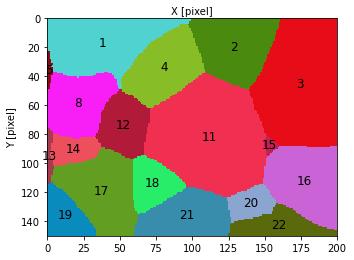

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='X [pixel]', ylabel='Y [pixel]'>)

In [11]:
m.view_slice(show_grain_ids=True, unit='pixel', show_mask=False)

vmin, vmax 0 None
handling hexagonal lattice


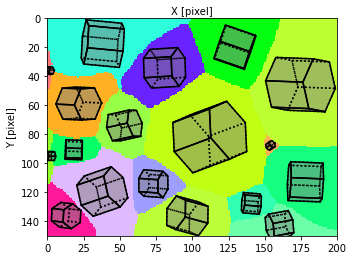

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='X [pixel]', ylabel='Y [pixel]'>)

In [12]:
m.view_slice(show_lattices=True, color='ipf', axis=[0, 0, 1], unit='pixel', show_mask=False)

vmin, vmax 0 None
handling hexagonal lattice


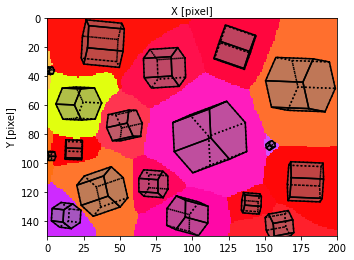

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='X [pixel]', ylabel='Y [pixel]'>)

In [13]:
m.view_slice(show_lattices=True, color='ipf', axis=[1, 0, 0], unit='pixel', show_mask=False)

#### Quaternion conversions

Sample code bits to start vectorizing quaternion conversions and utilization.

In [95]:
epsilon = np.finfo('float').eps

def up_axis(axis):
    if abs(axis[2]) > epsilon:
        if axis[2] < 0.:
            # reverse axis
            return -1. * axis
    elif abs(axis[1]) > epsilon:
        if axis[1] < 0:
            # reverse axis and zero z component
            return np.array([-axis[0], -axis[1], 0.])
    elif axis[0] < 0.:
        # reverse axis and zero y and z components
        return np.array([-axis[0], 0., 0.])
    return axis

In [ ]:
%%time
from pymicro.crystal.rotation import eu2qu

# classical approach with a double for loop
scan.quats = np.empty((list(scan.iq.shape) + [4]), float)
for i in range(200):
    for j in range(150):
        scan.quats[i, j] = eu2qu(scan.euler[i, j])

In [100]:
%%time

# vectorized code
eulers = np.reshape(scan.euler, (np.prod(scan.iq.shape), 3))
print(eulers.shape)
phi1, Phi, phi2 = np.squeeze(np.split(eulers, 3, axis=1))
q0 = np.cos(0.5 * (phi1 + phi2)) * np.cos(0.5 * Phi)
q1 = np.cos(0.5 * (phi1 - phi2)) * np.sin(0.5 * Phi)
q2 = np.sin(0.5 * (phi1 - phi2)) * np.sin(0.5 * Phi)
q3 = np.sin(0.5 * (phi1 + phi2)) * np.cos(0.5 * Phi)
quats = np.array([q0, q1, q2, q3]).T
# the scalar part must be positive
quats = quats * np.sign(q0).reshape([-1, 1])
# handle ambiguous rotation
ambig = np.where(quats[:, 0] < 3 * epsilon)[0]
for i in ambig:
    axis = up_axis(quats[i, 1:])
    quats[i] = np.array([0., *axis])
quats = quats.reshape(scan.quats.shape)
quats.shape

(30000, 3)
CPU times: user 7.86 ms, sys: 0 ns, total: 7.86 ms
Wall time: 7.05 ms


(200, 150, 4)

In [101]:
scan.quats[10:20, 100, :]

array([[0.046273  , 0.694397  , 0.06642312, 0.71502419],
       [0.04687285, 0.6945106 , 0.06622665, 0.71489299],
       [0.04605737, 0.69462841, 0.06594551, 0.71485752],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.25009336, 0.85137819, 0.17452051, 0.42679162],
       [0.25104799, 0.85124534, 0.17376268, 0.42680536],
       [0.25111993, 0.85065407, 0.17480916, 0.42751396],
       [0.25137591, 0.85057524, 0.17335452, 0.42811227],
       [0.25128357, 0.85010739, 0.17564728, 0.42816121]])

In [102]:
quats[10:20, 100, :]

array([[0.046273  , 0.694397  , 0.06642312, 0.71502419],
       [0.04687285, 0.6945106 , 0.06622665, 0.71489299],
       [0.04605737, 0.69462841, 0.06594551, 0.71485752],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.25009336, 0.85137819, 0.17452051, 0.42679162],
       [0.25104799, 0.85124534, 0.17376268, 0.42680536],
       [0.25111993, 0.85065407, 0.17480916, 0.42751396],
       [0.25137591, 0.85057524, 0.17335452, 0.42811227],
       [0.25128357, 0.85010739, 0.17564728, 0.42816121]])

In [ ]:
def eu2qu_series(euler):
    """Transform a series of euler angles into quaternions.

    :param ndarray euler: the (n, 3) shaped array of Euler angles (radians).
    :returns: a (n, 4) array with the quaternions.
    """
    if euler.ndim != 2 or euler.shape[1] != 3:
        raise ValueError('Wrong shape for the euler array: %s -> should be (n, 3)' % euler.shape)
    phi1, Phi, phi2 = np.squeeze(np.split(euler, 3, axis=1))
    q0 = np.cos(0.5 * (phi1 + phi2)) * np.cos(0.5 * Phi)
    q1 = np.cos(0.5 * (phi1 - phi2)) * np.sin(0.5 * Phi)
    q2 = np.sin(0.5 * (phi1 - phi2)) * np.sin(0.5 * Phi)
    q3 = np.sin(0.5 * (phi1 + phi2)) * np.cos(0.5 * Phi)
    if q0 < 0:
        # the scalar part must be positive
        q.quat = q.quat * -1
    # ambiguous rotation
    if q.quat[0] < 3 * epsilon:
        axis = upper_hemishpere_axis(q.quat[1:])
        q.quat = np.array([0., *axis])
    return q.quat


In [ ]:
def qu2euler_series(quats):
    """Transform a series of quaternions into euler angles.

    :param ndarray euler: the (n, 4) shaped array of quaternions.
    :returns: a (n, 3) array with the Euler angles (radians).
    """
    #TODO
    return None    

# now work on orientation matrix to quaternion conversion

In [73]:
from pymicro.crystal.rotation import eu2om

scan.oms = np.empty((list(scan.iq.shape) + [3, 3]), float)
for i in range(200):
    for j in range(150):
        scan.oms[i, j] = eu2om(scan.euler[i, j])

In [74]:
%%time
from pymicro.crystal.rotation import om2qu

# classical approach with a double for loop
scan.quats = np.empty((list(scan.iq.shape) + [4]), float)
for i in range(200):
    for j in range(150):
        scan.quats[i, j] = my_om2qu(scan.oms[i, j])

CPU times: user 257 ms, sys: 12.2 ms, total: 269 ms
Wall time: 260 ms


In [75]:
scan.quats[10:20, 100, :]

array([[ 0.046273  ,  0.694397  ,  0.06642312,  0.71502419],
       [ 0.04687285,  0.6945106 ,  0.06622665,  0.71489299],
       [ 0.04605737,  0.69462841,  0.06594551,  0.71485752],
       [ 1.        , -0.        , -0.        , -0.        ],
       [ 1.        , -0.        , -0.        , -0.        ],
       [ 0.25009336,  0.85137819,  0.17452051,  0.42679162],
       [ 0.25104799,  0.85124534,  0.17376268,  0.42680536],
       [ 0.25111993,  0.85065407,  0.17480916,  0.42751396],
       [ 0.25137591,  0.85057524,  0.17335452,  0.42811227],
       [ 0.25128357,  0.85010739,  0.17564728,  0.42816121]])

In [9]:
# ro2qu(om2ro(om)) method
scan.quats[10:20, 100, :]

array([[0.046273  , 0.694397  , 0.06642312, 0.71502419],
       [0.04687285, 0.6945106 , 0.06622665, 0.71489299],
       [0.04605737, 0.69462841, 0.06594551, 0.71485752],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.25009336, 0.85137819, 0.17452051, 0.42679162],
       [0.25104799, 0.85124534, 0.17376268, 0.42680536],
       [0.25111993, 0.85065407, 0.17480916, 0.42751396],
       [0.25137591, 0.85057524, 0.17335452, 0.42811227],
       [0.25128357, 0.85010739, 0.17564728, 0.42816121]])

In [15]:
# proper implementaion of om2qu (not vectorized)
def my_om2qu(om):
    q0 = 0.5 * np.sqrt(1 + om.trace())
    q1 = -0.5 * np.sqrt(1 + om[0, 0] - om[1, 1] - om[2, 2])
    q2 = -0.5 * np.sqrt(1 - om[0, 0] + om[1, 1] - om[2, 2])
    q3 = -0.5 * np.sqrt(1 - om[0, 0] - om[1, 1] + om[2, 2])
    if om[2, 1] < om[1, 2]:
        q1 *= -1
    if om[0, 2] < om[2, 0]:
        q2 *= -1
    if om[1, 0] < om[0, 1]:
        q3 *= -1
    qu = np.array([q0, q1, q2, q3])
    # normalize
    qu /= np.sqrt(np.sum(qu ** 2))
    return qu

In [38]:
%%time

# vectorized code
oms = np.reshape(scan.oms, (np.prod(scan.iq.shape), 3, 3))
print(oms.shape)
q0 = 0.5 * np.sqrt(1 + oms.trace(axis1=1, axis2=2))
q1 = -0.5 * np.sqrt(1 + oms[:, 0, 0] - oms[:, 1, 1] - oms[:, 2, 2])
q2 = -0.5 * np.sqrt(1 - oms[:, 0, 0] + oms[:, 1, 1] - oms[:, 2, 2])
q3 = -0.5 * np.sqrt(1 - oms[:, 0, 0] - oms[:, 1, 1] + oms[:, 2, 2])
# handle sign
q1 *= np.sign(oms[:, 2, 1] - oms[:, 1, 2])
q2 *= np.sign(oms[:, 0, 2] - oms[:, 2, 0])
q3 *= np.sign(oms[:, 1, 0] - oms[:, 0, 1])
quats = np.array([q0, q1, q2, q3]).T
print(quats.shape)
# normalize
quats /= np.sqrt(np.sum(quats ** 2, axis=1)).reshape([-1, 1])
quats = quats.reshape(scan.quats.shape)

(30000, 3, 3)
(30000, 4)
CPU times: user 2.27 ms, sys: 0 ns, total: 2.27 ms
Wall time: 1.76 ms


In [39]:
quats[10:20, 100, :]

array([[ 0.046273  ,  0.694397  ,  0.06642312,  0.71502419],
       [ 0.04687285,  0.6945106 ,  0.06622665,  0.71489299],
       [ 0.04605737,  0.69462841,  0.06594551,  0.71485752],
       [ 1.        , -0.        , -0.        , -0.        ],
       [ 1.        , -0.        , -0.        , -0.        ],
       [ 0.25009336,  0.85137819,  0.17452051,  0.42679162],
       [ 0.25104799,  0.85124534,  0.17376268,  0.42680536],
       [ 0.25111993,  0.85065407,  0.17480916,  0.42751396],
       [ 0.25137591,  0.85057524,  0.17335452,  0.42811227],
       [ 0.25128357,  0.85010739,  0.17564728,  0.42816121]])

In [50]:
def om2qu_series(oms):
    """Transform a series of orientation matrices into quaternions.

    :param ndarray euler: the (n, 3, 3) shaped array of orientation matrices.
    :returns: a (n, 4) array with the quaternions.
    """
    if oms.ndim != 3 or oms.shape[1] != 3:
        raise ValueError('Wrong shape for the orientation matrices array: %s -> should be (n, 3, 3)' % oms.shape)
    q0 = 0.5 * np.sqrt(1 + oms.trace(axis1=1, axis2=2))
    q1 = -0.5 * np.sqrt(1 + oms[:, 0, 0] - oms[:, 1, 1] - oms[:, 2, 2])
    q2 = -0.5 * np.sqrt(1 - oms[:, 0, 0] + oms[:, 1, 1] - oms[:, 2, 2])
    q3 = -0.5 * np.sqrt(1 - oms[:, 0, 0] - oms[:, 1, 1] + oms[:, 2, 2])
    # handle sign
    q1 *= np.sign(oms[:, 2, 1] - oms[:, 1, 2])
    q2 *= np.sign(oms[:, 0, 2] - oms[:, 2, 0])
    q3 *= np.sign(oms[:, 1, 0] - oms[:, 0, 1])
    quats = np.array([q0, q1, q2, q3]).T
    print(quats.shape)
    # normalize
    quats /= np.sqrt(np.sum(quats ** 2, axis=1)).reshape([-1, 1])
    return quats


In [51]:
# test our new function
quats = om2qu_series(np.reshape(scan.oms, (np.prod(scan.iq.shape), 3, 3)))
quats = quats.reshape(scan.quats.shape)

(30000, 4)


In [52]:
quats[10:20, 100, :]

array([[ 0.046273  ,  0.694397  ,  0.06642312,  0.71502419],
       [ 0.04687285,  0.6945106 ,  0.06622665,  0.71489299],
       [ 0.04605737,  0.69462841,  0.06594551,  0.71485752],
       [ 1.        , -0.        , -0.        , -0.        ],
       [ 1.        , -0.        , -0.        , -0.        ],
       [ 0.25009336,  0.85137819,  0.17452051,  0.42679162],
       [ 0.25104799,  0.85124534,  0.17376268,  0.42680536],
       [ 0.25111993,  0.85065407,  0.17480916,  0.42751396],
       [ 0.25137591,  0.85057524,  0.17335452,  0.42811227],
       [ 0.25128357,  0.85010739,  0.17564728,  0.42816121]])

In [77]:
# extract orientation data for a given grain
gid = 4
quats_gid = scan.quats[np.where(scan.grain_ids == 4)]
print(quats_gid.shape)

(1926, 4)


In [80]:
# compute mean orientation without worrying about fundamental zone (should be ok in most cases)
print(quats_gid)
mean_quat = np.mean(quats_gid, axis=0)
mean_quat /= np.sqrt(np.sum(mean_quat ** 2))
mean_quat

[[0.17412858 0.81108016 0.21505552 0.5153439 ]
 [0.17399917 0.81140406 0.21597375 0.51449303]
 [0.17241454 0.8091774  0.21789804 0.5177119 ]
 ...
 [0.17337533 0.81030649 0.21780625 0.5156596 ]
 [0.1736383  0.8106347  0.21654107 0.51558811]
 [0.17154342 0.81098594 0.21533659 0.51624104]]


array([0.17444254, 0.81010276, 0.21736238, 0.51580705])

In [84]:
from pymicro.crystal.microstructure import Orientation
from pymicro.crystal.rotation import qu2om

o_mean = Orientation(qu2om(mean_quat))
o_mean.inFZ(symmetry=sym)

False

# new code to compute mean orientation with quaternion list

In [53]:
from pymicro.crystal.lattice import Symmetry
sym = Symmetry.hexagonal
syms = sym.symmetry_operators()
print(syms.shape)
om2qu_series(syms)

(12, 3, 3)
(12, 4)


<ipython-input-50-7a78c448c027>:20: RuntimeWarning: invalid value encountered in true_divide
  quats /= np.sqrt(np.sum(quats ** 2, axis=1)).reshape([-1, 1])


array([[ 1.       , -0.       , -0.       , -0.       ],
       [ 0.8660254, -0.       , -0.       ,  0.5      ],
       [ 0.5      , -0.       , -0.       ,  0.8660254],
       [       nan,        nan,        nan,        nan],
       [ 0.5      , -0.       , -0.       , -0.8660254],
       [ 0.8660254, -0.       , -0.       , -0.5      ],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan]])

In [ ]:
# work in progress...
def compute_mean_quaternion(quats, symmetry=Symmetry.cubic):
    """Compute the mean orientation as a quaternion.

    This function computes a mean orientation from several data points
    representing orientations by averaging the corresponding Quaternions
    while taking all the crystal symmetries into account.

    :param ndarray rods: a (n, 4) shaped array containing the Quaternions
    representing the orientations.
    :param `Symmetry` symmetry: the symmetry used to move orientations
    to their fundamental zone (cubic by default)
    :returns: the mean orientation as a quaternion.
    """
    syms = symmetry.symmetry_operators()  #TODO replace by quaternions versions

    # apply all symmetries to compute Rodrigues vectors
    quats_syms = np.zeros((len(syms), len(quats), 4), dtype=float)
    for i in range(len(quats)):
        # apply all symmetries
        XXX q_syms = np.dot(syms, g)
        for j in range(len(syms)):
            # compute the quaternion for each symmetry
            quats_syms[j, i] = XXX

    # we now apply kmeans clustering in quaternion space
    X = rods_syms.reshape((len(syms) * len(rods), 3))
    Q = np.empty((len(X), 4), dtype=float)
    for i in range(len(X)):
        Q[i] = ro2qu(X[i])
    # we need to initialize the centroid with one point in each zone
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=len(syms),  # number of clusters = nb of symmetry operators
                    init=Q[::len(rods)],  # explicit centroids
                    n_init=1).fit(Q)

    # now compute the mean orientation for each cluster
    mean_quats_syms = np.empty((len(syms), 4), dtype=float)
    for j in range(len(syms)):
        #mean_rods_syms[j] = np.mean(X[kmeans.labels_ == j], axis=0)
        mean_quat_syms_j = np.mean(Q[kmeans.labels_ == j], axis=0)
        mean_quat_syms_j /= np.sqrt(np.sum(mean_quat_syms_j ** 2))
    # find which orientation belongs to the FZ
    if symmetry == Symmetry.cubic:
         index_fz = np.argmax([(np.abs(r).sum() <= 1.0) and
                               (np.abs(r).max() <= 2 ** 0.5 - 1)
                               for r in qu2ro(mean_quat_syms)])
    elif symmetry == Symmetry.hexagonal:
        index_fz = np.argmax([Orientation.fzDihedral(r, 6)
                              for r in qu2ro(mean_quat_syms)])
    else:
        raise (ValueError('unsupported crystal symmetry: %s' % symmetry))

    return mean_quats_syms[index_fz]
